In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import logging
from pathlib import Path
import textwrap
import copy
from PIL import Image, ImageDraw, ImageFont
from waveshare_epd import epd2in7b

In [4]:
import constants


In [5]:
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

In [11]:
class TextBlock:
    '''Class for creating a 1 bit image of word-wrapped text
    
    Args
    ----
        resolution (int, int): tuple of ints representing maximum resolution of image
        text (str): text to format into image
        font (str): path to ttf font
        size (int): size of font in points (pixles)
        maxrows (int): maximum number of wrapped rows of text; surplus is discarded
        maxchar (int): maximum number of characters per row
            this is automatically calculated if not specified based on font face, font size
            and letter frequency (see chardist below)
        chardist (dict): character frequency distribution for a particular language
            provided distributions in constants.py: 
            USA_CHARDIST+, FRA_CHARDIST, DEU_CHARDIST, PRT_CHARDIST, ITA_CHARDIST, TUR_CHARDIST,
            SWE_CHARDIST, NED_CHARDIST, DAN_CHARDIST
                + only USA english includes upper and lower case characters
        coordinates (int, int): location on screen image should be positioned (not used locally)
    
    Attributes
    ----------
        resolution (int, int): max resolution of image in px
        font (ImageFont.trueType): font and size to use
        maxchar (int): maximum number of characters per row
        maxrows (int): maximum number of wrapped rows of text; surplus is discarded
        coordinates (int, int): position of text in final image (not used in this class)
        size (int, int): size of text image in px
        text (str): raw text
        formatted (str): wrapped text
        textimage (ImageDraw.Draw): 1 bit image containing formatted text text


    '''
    def __init__(self, resolution=(246, 176), text=' ', font=constants.FONT, size=24, maxrows=3,
                 maxchar=None, coordinates=(0, 0), chardist=constants.USA_CHARDIST):
        self.resolution=resolution
        self.font = ImageFont.truetype(str(Path(font).absolute()), size)
        self._chardist = chardist
        self.maxchar = maxchar
        self.maxrows = maxrows
        self.coordinates = coordinates
        self.size = (0, 0)
        self.text = text
    
        
    @property
    def resolution(self):
        '''maximum resolution in for image
        
        ::2-tuple of int'''
        return self._resolution
    
    @resolution.setter
    def resolution(self, resolution):
#         for r in resolution:
#             if not isinstance(r, int):
#                 raise TypeError(f'resolution must be type int: {r}')
#             if r < 0:
#                 raise ValueError(f'resolution must be positive: {r}')
        if self.coordcheck(resolution):
            self._resolution = resolution
        else:
            raise ValueError(f'bad resolution value: {resolution}')
    
    @property
    def coordinates(self):
        '''coordinates to place the formatted text within the final image (not used in this method)
        
        ::2 tuple of int'''
        return self._coordinates
    
    @coordinates.setter
    def coordinates(self, coordinates):
        if self.coordcheck(coordinates):
            self._coordinates = coordinates
        else:
            raise ValueError(f'bad coordinate values: {coordinates}')
    
    @property
    def maxchar(self):
        '''maximum number of characters per row
            if no value is set this is calculated based on font face, font size and letter frequency
            
        ::int'''
        return self._maxchar
    
    @maxchar.setter
    def maxchar(self, maxchar):
        if maxchar:
            self.__maxchar = maxchar
            return(maxchar)
        else:
            s = ''
            n = 1000 # sample string size for measuring
            # create a string of characters containing the letter distribution
            for char in self._chardist:
                s = s+(char*int(self._chardist[char]*n))
            logging.debug(f'using font: {self.font.getname()}, size: {self.font.size}')
            logging.debug(f'Created string of {len(s)} chars')
            sLenPX = self.font.getsize(s)[0] # string length in Pixles
            avgCharLen = sLenPX/len(s)
            maxchar = round(self.resolution[0]/avgCharLen)
            logging.debug(f'resolution (x): {self.resolution[0]}')
            logging.debug(f'length in px: {sLenPX}, avg char length: {avgCharLen}, max chars per row: {maxchar}')
            self._maxchar = maxchar
    
    @property
    def text(self):
        '''raw text
        
        ::str'''
        return self._text
    
    @text.setter
    def text(self, text):
        if not text:
            text = ''
        
        self._text = text
        self.formatted = self.formattext()
    
    @property
    def maxrows(self):
        '''maximum number of rows to use when wrapping text
        
        ::int'''
        return self._maxrows
    
    @maxrows.setter
    def maxrows(self, maxrows):
        if maxrows < 1:
            raise ValueError(f'maxrows must be greater than 0: {maxrows}')
        if not isinstance(maxrows, int):
            raise ValueError(f'maxrows must be type integer: {maxrows}')
        self._maxrows = maxrows
    
    def formattext(self, text=None, maxchar=None, maxrows=None):
        '''format text using word-wrap strategies
        
        Args
        ----
            text (str): raw text
            maxchar (int): maximum number of characters in each row
            maxrow (int): maximum number of rows
            
        Returns
        -------
            ::str'''
        if not maxchar:
            maxchar = self.maxchar
        if not maxrows:
            maxrows = self.maxrows
        if not text:
            text = self.text
        
        wrapper = textwrap.wrap(text, width=maxchar)
        myText = "\n".join(wrapper[0:maxrows])
        if len(myText) < 1:
            myText = ' '
        return(myText)
    
    def textimage(self, text=None, coordinates=None):
        '''produces 1 bit image of containing wrapped text
        
        Args
        ----
            text (str): raw text to use; if non is provided use self.text
            coordinates (int): coordinates of text in final image (not used in this class)
            
        Returns
        -------
            ::Image.new()'''
        if text:
            text = self.formattext(text)
        else:
            text = self.formatted
            
        if not coordinates:
            coordinates = self.coordinates

        # get the size of the text
        draw = ImageDraw.Draw(Image.new('1', (1, 1))) # create a dummy image and drawing instance
        self.size = draw.textsize(text, self.font)
        
        logging.debug(f'text size: {self.size}')
        # create an empty image
        image = Image.new('1', self.size, 255) # create a blank image 
        # get a drawing context
        draw = ImageDraw.Draw(image)
#         draw.text        
        draw.text((0,0), text, font=self.font) # draw the text at the origin
        self.image = image
        return image

    def coordcheck(self, coordinates):
        for c in coordinates:
            if not isinstance(c, int):
                raise TypeError(f'coordinate must be type int: {c}')
                return False # redundant
            if c < 0:
                raise ValueError(f'coordinate must be positive: {c}')
                return False # redundant
        return True

In [12]:
t = TextBlock(text='Father of the Bride', size=36)

DEBUG:root:using font: ('Open Sans', 'Regular'), size: 36
DEBUG:root:Created string of 1978 chars
DEBUG:root:resolution (x): 246
DEBUG:root:length in px: 40405, avg char length: 20.427199191102122, max chars per row: 12


DEBUG:root:text size: (154, 82)


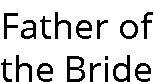

In [13]:
t.textimage()

In [ ]:
t.size

In [ ]:
class xTextBlock:
    '''Class for creating blocks of formatted and wrapped text as images using PIL(Pillow)
    
    Args
    ----
        resolution (2-tuple): width (x), height (y) in pixles of canvas
        font (Path): path to ttf font
        size (int): size in points to use for rendering text
        maxRows (int): maximum number of rows to produce (overflow rows will be discarded)
        text (str): unformatted text
        charPerRow (int): maximum number of rows to use per row
            this is automatically calculated using font, display size and english letter 
            distribution. Other letter distributions can be provided see CHARDIST
        charDist (dict): letter use distribution for calculating maximum number of char/row 
            for character set. Default set is for [A..Z, a..z].
            Format: CHARDIST = {'A': 0.0796394951934866, 'B': 0.0480421724743304,}
            For more languages see: 
                * https://en.wikipedia.org/wiki/Letter_frequency 
                * https://www.sttmedia.com/characterfrequencies
            
    Attributres
    -----------
        height (int): height in pixles of the display
        width (int): width in pixles of the display
        coordinates (int, int): tuple that indicates the starting position of the text block
        size (int, int): x, y size in pixles of text block
        font (str): path to ttf font
        text (str): unformatted text
        charPerRow (int): maximum number of characters to allow per row before wrapping
        maxRows (int): maximum number of rows of text to produce (overflow rows will be discarded)
        formattedText (str): word-wrapped text
        
    '''
    def __init__(self, resolution=(264, 176), font=constants.FONT, size=24, maxRows=3, text=' ',
                  coordinates=(0, 0), charPerRow=None, charDist=constants.USA_CHARDIST):
        self.height = resolution[0]
        self.width = resolution[1]
        self.font = self.setFont(fontPath=font, size=size)
        self.__charDist = charDist
        self.charPerRow = charPerRow
        self.maxRows = maxRows
        self.coordinates = coordinates
        self.text = text
        self.size = None
        self.image = None
        
    def setFont(self, fontPath, size):
        '''Get a ttf font
        Args
        ----
            fontPath (str): path to font (can be relative)
            size (int): size in points/pixles of font
            
        Returns
        -------
            PIL.ImageFont.truetype object'''

        logging.debug(f'font: {Path(fontPath).absolute()}, exists: {Path(fontPath).exists()}')
        font = ImageFont.truetype(str(Path(fontPath).absolute()), size)
        return(font)
    
    
    @property
    def charPerRow(self):
        '''int: Calculated maximum number of characters per row before wrapping
            Calculations are based on font, font size and width of canvas (x)'''
        return self.__charPerRow
    
    @charPerRow.setter
    def charPerRow(self, charPerRow):
        if charPerRow:
            self.__charPerRow = charPerRow
            return(charPerRow)
        s = ''
        n = 1000
        testFont = self.font
        # create a string of characters containing the letter distribution
        for char in self.__charDist:
            s = s+(char*int(self.__charDist[char]*n))
        logging.debug(f'using font: {self.font.getname()}, size: {self.font.size}')
        logging.debug(f'Created string of {len(s)} characters')
        sLenPX = testFont.getsize(s)[0] # string length in Pixles
        avgCharLen = sLenPX/len(s)
        charPerRow = round(self.height/avgCharLen)
        logging.debug(f'length in px: {sLenPX}, avg char length: {avgCharLen}, max chars per row: {charPerRow}')
        self.__charPerRow = charPerRow
        
    @property
    def text(self):
        '''str: unformatted text
        Sets
        ----
        text (str): unformatted text
        formattedText(str): wrapped text
        image (PIL Image): canvas containing formatted text
        size (int, int): tuple of x, y size of formatted text'''
        return self.__text

    @text.setter
    def text(self, text):
        if not text:
            text = ' '
        self.__text = text
        self.formattedText = self.wrapText(text)
        self.image, self.size = self.textImg()
        
    def wrapText(self, text=' ', charPerRow=None, maxRows=None):
        '''return a formatted text block of N rows using new line characters (\n)
        Args
        ----
        text (str): string to format
        charPerRow (int): maximum number of characters per row before wrapping
        maxRows (int): maximum number of rows to return -- overflow is discarded
        
        Returns
        -------
        string'''
        logging.debug(f'text length: {len(text)}')
        if not charPerRow:
            charPerRow = self.charPerRow
        if not maxRows:
            maxRows = self.maxRows
        try:
            wrapper = textwrap.wrap(text, width=charPerRow)
        except AttributeError as e:
            raise ValueError(f'Attribute Error: {text} is not a string; it appears to be {type(text)}')
        myText = "\n".join(wrapper[0:maxRows])
        if len(myText) < 1:
            myText = ' '
        return(myText)
    
    def textImg(self, text=None, coordinates=None):
        '''retun an PIL image containing the formatted text
        Args
        ----
        text (str): unformatted text to create into an image
        coordinates (int, int): tuple of integers for starting position of text on canvas
        
        Returns
        -------
        PIL image with formatted text'''
        logging.debug('creating text image')
        image = Image.new('1', (self.height, self.width), 255) # create a blank image 
        # get a drawing context
        draw = ImageDraw.Draw(image) # cr
        if text:
            myText = self.wrapText(text)
        else:
            myText = self.formattedText
            
        if not coordinates:
            coordinates = self.coordinates
        logging.debug(f'using text: {myText}')
        
        draw.text(coordinates, myText, font=self.font, fill=0)
        textsize = draw.textsize(myText)
        
        # return the altered image
        return(image, textsize)
    
    

In [ ]:
f = ImageFont.truetype(str(Path(constants.FONT).absolute()), 24)
im = Image.new('1', (1,1))
draw = ImageDraw.Draw(im)
draw.textsize('hello world\nhello world', f)

In [ ]:
f.getsize("hello world\hello world")

In [ ]:
epd = epd2in7b.EPD()
title = TextBlock(resolution=(epd.height, epd.width), maxRows=3, size=24, coordinates=(0, 0))
artist = TextBlock(resolution=(epd.height, epd.width), maxRows=2, size=18)
blank = TextBlock(resolution=(epd.height, epd.width))

In [ ]:
title.text = "Horchata"
artist = TextBlock(resolution=(epd.height, epd.width), maxRows=2, size=8, coordinates=title.coordinates)
artist.text = 'Vampire Weekend'

In [ ]:
track.text = 'Old education him departure any arranging one prevailed. Their end whole might began her. Behaved the comfort another fifteen eat. Partiality had his themselves ask pianoforte increasing discovered. So mr delay at since place whole above miles. He to observe conduct at detract because. Way ham unwilling not breakfast furniture explained perpetual. Or mr surrounded conviction so astonished literature. Songs to an blush woman be sorry young. We certain as removal attempt.'

In [ ]:
track.image

In [ ]:
empty.text = ' '

In [ ]:
empty.text

In [ ]:
empty.formattedText

In [ ]:
empty.image

In [ ]:
epd.init()

In [ ]:
epd.display(epd.getbuffer(track.image), epd.getbuffer(empty.image))

In [ ]:
class formatter:
    def __init__(self, text, charPerRow):
        self.rows = rows
        self.charPerRow = charPerRow
        self.text = text
        
    @property
    def text(self):
        return self.__text
    
    @text.setter
    def text(self, text):
        self.__text = text
        self.formatedText = self.fmt(text, rows=self.rows, charPerRow=self.charPerRow)
        
    def fmt(self, text, rows, charPerRow):
        wrapper = textwrap.wrap(text, width=charPerRow)
        myText = "\n".join(wrapper[0:maxRows])
        return(myText)

In [ ]:
track.font.getname()